In [91]:
## Bring in needed ods
import pandas as pd, numpy as np, scipy.stats as ss
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

## write ftns for analysis
def allelic_ANOVA(site, pheno):
    """
    This regression is equivalent to one-way ANOVA with 2 groups. 
    Return F-statistic.
    Assumes site is coded as -1, 1
    """
    coding = np.array(site, np.float)
    pheno = np.array(pheno, np.float)
    
    meany = np.mean(pheno)
    meandummy = np.mean(coding)
    ctry = pheno - meany
    ctrdummy = coding - meandummy
    
    # regression coefficient and intercept
    b = np.dot(ctry, ctrdummy)/np.dot(ctrdummy, ctrdummy)
    intercept = meany - b * meandummy
    
    yhat = b * ctrdummy
    len_yhat = np.sqrt(np.dot(yhat,yhat))
    len_y = np.sqrt(np.dot(ctry,ctry))
    df_yhat = 1
    
    error = ctry  - yhat
    len_error = np.sqrt(np.dot(error,error))
    if abs(len_error**2) < 1e-5:
        raise Exception("Zero length error in ANOVA")
    df_error = len(pheno) - 2
    
    # coefficient of determination is R**2
    #R = len_yhat/len_y
    # F-statistic
    F = (len_yhat**2/df_yhat) / (len_error**2/df_error)
    return F

def association_logPval(site, pheno):
    F = allelic_ANOVA(site, pheno)
    logP = np.log10(ss.f.sf(F, 1, len(pheno)-2))
    return -logP

def crypto_kruskal(site,pheno):
    refxpheno = np.array(pheno,dtype=float)[np.array(site)==0]
    altxpheno = np.array(pheno,dtype=float)[np.array(site)==1]
    return -np.log10(ss.kruskal(refxpheno,altxpheno)[1])

def crypto_wilcox(site,pheno):
    refxpheno = np.array(pheno,dtype=float)[np.array(site)==0]
    altxpheno = np.array(pheno,dtype=float)[np.array(site)==1]
    return -np.log10(ss.wilcoxon(refxpheno,altxpheno)[1])

## Define ftns for use in QTL mapping
def allelic_manu(geno,pheno,x=0,y=1): ## geno and pheno need to be in the same position
    """
    Conducts a Mann-Whitney U test on the phenotype data in PHENO
    by the genotypic states listed in GENO.
    
    Assumes the order of data within GENO and PHENO are paired.
    Defaluts for the biallelic stat in GENO are 0 and 1; set in X and Y.
    
    Returns the -log10 of the calculated p-value
    """
    pheno = np.array(pheno) ## sets the type for the data as an array
    geno = np.array(geno)
    ## Gather phenotypes by genotypes 
    ## Parse the genotype data as True for 0 and then 1 and 
    ## take the asscoiated index within the phenotypic data array
    ## Return p-value
    return -np.log10(ss.mannwhitneyu(pheno[(geno==x)],pheno[(geno==y)])[1])

In [2]:
## Load genotype data
genotype_path = '/home/croth/crypto-QTL-paper/DATA/GENOTYPE/CDx-ill-SNP-INDEL-df-104-blocked.csv.gz'
gv = pd.read_csv(genotype_path)
gv.head()

,Chrom,Pos,Qual,Callrate,Ref,Alt,Altlen,Dp,Type,Vcfix,...,SS-B598,SS-B565,SS-B600,SS-B574,SS-B872_cor,SS-B873_cor,SS-B360,SS-B397,SS-B564,SS-B382
0,Chr01,5016,104492.0,1.0,C,A,1,6510,snp,289,...,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
1,Chr01,5299,112647.0,1.0,T,C,1,9711,snp,293,...,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
2,Chr01,5464,112658.0,1.0,T,C,1,9375,snp,294,...,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
3,Chr01,6120,109003.0,1.0,T,C,1,9311,snp,311,...,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
4,Chr01,6166,114638.0,1.0,G,A,1,9269,snp,312,...,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0


In [3]:
old_data_path = '../../PHENOTYPE/XL280x431/XL280x431_cross_amoeba_roth_processed_01_26_2021.csv'
olda = pd.read_csv(old_data_path,index_col=0)
olda['Halo'] = olda['Area.12']
olda.reset_index(drop=True)
old = olda[(olda.Sample.isin(gv.columns))].dropna()
old.head()

,Strain,Replicate,Stack,passage,plate,Area.1,Area.12,Sample,Halo
0,431alpha,1,2,10,p2_1,1.470965,11.658041,SS-A837,11.658041
1,431alpha,1,1,11,p1_1,1.587094,17.741900,SS-A837,17.741900
2,B307,1,3,10,p2_1,4.122572,30.490262,SS-B307,30.490262
4,B310,1,5,10,p2_1,1.219352,11.341913,SS-B310,11.341913
5,B311,1,4,10,p2_1,0.987095,6.670954,SS-B311,6.670954


In [4]:
dropped = [i for i in olda.index.tolist() if i not in old.index.tolist()]

In [5]:
olda.loc[dropped]

,Strain,Replicate,Stack,passage,plate,Area.1,Area.12,Sample,Halo
3,B308,1,2,10,p2_1,0.567741,11.967718,B308,11.967718
13,B353,1,4,11,p1_1,0.638708,4.645152,B353,4.645152
25,B376,1,4,11,p1_1,1.419352,49.509578,B376,49.509578
26,B377,1,1,10,p2_1,2.270963,24.212855,B377,24.212855
34,B410,1,4,10,p2_1,0.967740,5.774182,B410,5.774182
35,B518,1,4,10,p2_1,1.922577,10.129012,B518,10.129012
46,B580,1,1,11,p1_1,1.561287,NaN,SS-B580,NaN
49,B586,1,1,11,p1_1,1.051611,NaN,SS-B586,NaN
58,B869,1,5,10,p2_1,1.361288,26.303173,B869,26.303173
62,B873,1,5,10,p2_1,3.367735,19.064478,B873,19.064478


In [6]:
old.shape

(94, 9)

In [8]:
new_data_path = '../../PHENOTYPE/XL280x431/XL280x431_cross_amoeba_full_01_2021.csv'
new = pd.read_csv(new_data_path)

new['Area_in2'] = new.Area
new['Area_cm2'] = new.Area_in2*cm2
new.head()

,Strain,Day,Replicate,Stack,plate,passage,Area,Mean,Min,Max,issues,Area_in2,Area_cm2
0,B960,1,1,1,p2_1,10,0.268,20737.321,18336.0,23488.0,NaN,0.268,1.729029
1,B377,1,1,1,p2_1,10,0.352,20349.177,17239.0,25692.0,NaN,0.352,2.270963
2,C031,1,1,1,p2_1,10,0.030,19746.096,18081.0,24509.0,NaN,0.030,0.193548
3,B560,1,1,1,p2_1,10,0.786,20653.039,16551.0,27029.0,NaN,0.786,5.070958
4,B313,1,1,1,p2_1,10,0.598,20776.284,17215.0,25699.0,NaN,0.598,3.858057


In [9]:
Strain_names = []
Dont_rep = []
for i,j in new.iterrows():
    
    s = j.Strain
    
    if s in gv.columns:
        Strain_names.append(s)
    
    elif 'SS-'+s in gv.columns:
        Strain_names.append('SS-'+s)
            
    elif s == '431alpha':
        Strain_names.append('SS-A837')
    elif s == 'KN99':
        Strain_names.append('KN99')
    else:
        Dont_rep.append('SS-'+s)
        Strain_names.append(s)

print(len(Strain_names))
print(Strain_names[:10])
print(len(Dont_rep))

716
['B960', 'B377', 'C031', 'SS-B560', 'SS-B313', 'SS-B887_cor', 'SS-C272', 'SS-C242', 'SS-C031_cor', 'SS-B316']
98


In [10]:
len(np.unique(Dont_rep))

32

In [11]:
new['Sample'] = Strain_names
new.sort_values(['Sample','plate','Day'],inplace=True)

In [12]:
new.head()

,Strain,Day,Replicate,Stack,plate,passage,Area,Mean,Min,Max,issues,Area_in2,Area_cm2,Sample
251,B308,1,2,1,2_2-1_2_firsthalf,4,0.059,38503.193,34184.0,45535.0,NaN,0.059,0.380644,B308
312,B308,12,2,1,2_2-1_2_firsthalf,4,1.494,37947.130,32805.0,48070.0,NaN,1.494,9.638690,B308
15,B308,1,1,2,p2_1,10,0.088,21161.915,18281.0,27070.0,NaN,0.088,0.567741,B308
139,B308,12,1,2,p2_1,10,1.943,20230.177,11916.0,40737.0,NaN,1.943,12.535459,B308
103,B353,1,1,4,p1_1,11,0.099,20397.899,17770.0,25226.0,NaN,0.099,0.638708,B353


In [13]:
new[['Replicate','Stack','plate','passage']].drop_duplicates()

,Replicate,Stack,plate,passage
251,2,1,2_2-1_2_firsthalf,4
15,1,2,p2_1,10
103,1,4,p1_1,11
288,2,4,2_2-1_2_firsthalf,4
371,2,1,2_2-1_2_secondhalf,5
1,1,1,p2_1,10
47,1,4,p2_1,10
609,3,1,2_3-1_3_firsthalf,7
306,2,5,2_2-1_2_firsthalf,4
265,2,2,2_2-1_2_firsthalf,4


In [14]:
new.Day.unique()

array([ 1, 12])

In [15]:
newold = new[(new.plate.isin(old.plate)) & 
             (new.passage.isin(old.passage)) & 
             (new.Sample.isin(gv.columns))]
newold.shape

(204, 14)

In [16]:
nog = [d for a,d in newold.groupby(['Sample','plate'])]

In [17]:
newold_halos = []
check = []

waitix = [65,189]

for n in nog:
    if n.shape[0] != 2:
        check.append(n)
        
        n = n.loc[[i for i in n.index if i not in waitix]]

    halo = n.sort_values('Day')['Area_cm2'].diff().min()
    strain = n.Sample.min()
    plate = n.plate.min()
    stack = n.Stack.min()
    passage = n.passage.min()
    
    newold_halos.append((strain,plate,stack,passage,halo))

halos_newold = pd.DataFrame(newold_halos,
                columns=['Sample','Plate',
                'Stack','Passage','Halo']
                           ).sort_values('Sample')
halos_newold.head()

,Sample,Plate,Stack,Passage,Halo
0,SS-A837,p1_1,1,11,17.741900
1,SS-A837,p2_1,2,10,11.658041
2,SS-B307,p2_1,3,10,30.490262
3,SS-B310,p2_1,5,10,11.341913
4,SS-B311,p2_1,4,10,6.670954


In [18]:
check[0]

,Strain,Day,Replicate,Stack,plate,passage,Area,Mean,Min,Max,issues,Area_in2,Area_cm2,Sample
62,B872_cor,1,1,1,p1_1,11,0.221,21052.805,18669.0,24701.0,NaN,0.221,1.425804,SS-B872_cor
65,B872_cor,1,1,1,p1_1,11,0.796,20867.937,17782.0,28622.0,NaN,0.796,5.135474,SS-B872_cor
186,B872_cor,12,1,1,p1_1,11,3.928,20990.584,7638.0,29477.0,NaN,3.928,25.341885,SS-B872_cor
189,B872_cor,12,1,1,p1_1,11,2.355,20058.342,17524.0,31762.0,NaN,2.355,15.193518,SS-B872_cor


In [19]:
halos_newold.shape

(101, 5)

In [20]:
halos_newold.Sample.unique().shape

(97,)

In [21]:
strains_added = [s for s in halos_newold.Sample if s 
 not in old.Sample.unique().tolist()]

In [22]:
halos_newold[~(halos_newold.Sample.isin(strains_added))].shape

(94, 5)

In [23]:
halos_newold_mean = halos_newold.groupby('Sample').mean()
halos_newold_mean.shape

(97, 3)

In [24]:
halos_newold_mean.head()

,Stack,Passage,Halo
Sample,,,
SS-A837,1.5,10.5,14.699971
SS-B307,3.0,10.0,30.490262
SS-B310,5.0,10.0,11.341913
SS-B311,4.0,10.0,6.670954
SS-B312,5.0,10.0,22.619310


In [25]:
old_mean = old.groupby('Sample').mean().sort_values('Sample')
old_mean.shape

(90, 6)

In [26]:
old_mean.head()

,Replicate,Stack,passage,Area.1,Area.12,Halo
Sample,,,,,,
SS-A837,1.0,1.5,10.5,1.529029,14.699971,14.699971
SS-B307,1.0,3.0,10.0,4.122572,30.490262,30.490262
SS-B310,1.0,5.0,10.0,1.219352,11.341913,11.341913
SS-B311,1.0,4.0,10.0,0.987095,6.670954,6.670954
SS-B312,1.0,5.0,10.0,4.432249,22.619310,22.619310


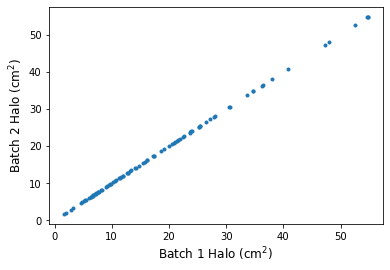

In [27]:
plt.plot(old_mean.Halo.values,
         halos_newold_mean.loc[
             old_mean.index,'Halo'],'.');
plt.xlabel('Batch 1 Halo (cm$^2$)',fontsize=12)
plt.ylabel('Batch 2 Halo (cm$^2$)',fontsize=12);

In [28]:
## Cunduct QTL mapping on old 1st batch of data
## This should match our previous run
loci = gv[old_mean.index].drop_duplicates()
assert loci.shape[1] == len(np.unique(old_mean.index))
loci['Old'] = loci.apply(allelic_manu,
                args=[old_mean.Halo.values],axis=1)

## Merge results
qtldf = gv.merge(loci)


## Cunduct QTL mapping on "new" 1st batch of data
## This dosn't include 7 samples of p1 and p2
loci = gv[old_mean.index].drop_duplicates()
assert loci.shape[1] == len(np.unique(old_mean.index))

temp = halos_newold_mean.loc[old_mean.index,'Halo'].values

loci['Old_test'] = loci.apply(allelic_manu,args=[temp],axis=1)

## Merge results
qtldf['Old_test'] = gv.merge(loci)['Old_test']

In [29]:
## Cunduct QTL mapping on "newest" replicate one data
## Base one plates (p1 p2)
## This shoudl be ~ 97 samples
loci = gv[halos_newold_mean.index].drop_duplicates()
assert loci.shape[1] == len(np.unique(halos_newold_mean.index))

temp = halos_newold_mean.Halo.values
print(len(temp))
loci['New_old_test'] = loci.apply(allelic_manu,args=[temp],axis=1)

## Merge results
qtldf['New_old_test'] = gv.merge(loci)['New_old_test']

## View head
qtldf.head()

97


,Chrom,Pos,Qual,Callrate,Ref,Alt,Altlen,Dp,Type,Vcfix,...,SS-B574,SS-B872_cor,SS-B873_cor,SS-B360,SS-B397,SS-B564,SS-B382,Old,Old_test,New_old_test
0,Chr01,5016,104492.0,1.0,C,A,1,6510,snp,289,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.493562,0.493562,0.378623
1,Chr01,5299,112647.0,1.0,T,C,1,9711,snp,293,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.493562,0.493562,0.378623
2,Chr01,5464,112658.0,1.0,T,C,1,9375,snp,294,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.493562,0.493562,0.378623
3,Chr01,6120,109003.0,1.0,T,C,1,9311,snp,311,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.493562,0.493562,0.378623
4,Chr01,6166,114638.0,1.0,G,A,1,9269,snp,312,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.493562,0.493562,0.378623


In [30]:
## Estimate and gather maximum chromosome length
chrommap = qtldf.groupby('Chrom')['Pos'].max().reset_index()

chrommap['Cumlen'] = [0] + chrommap.Pos.cumsum().tolist()[:-1]
chrommap['Midpts'] = (chrommap.Pos.values/2) + chrommap.Cumlen.values

chrommap.head()

,Chrom,Pos,Cumlen,Midpts
0,Chr01,2295469,0,1147734.5
1,Chr02,1623022,2295469,3106980.0
2,Chr03,2100376,3918491,4968679.0
3,Chr04,1777939,6018867,6907836.5
4,Chr05,1451825,7796806,8522718.5


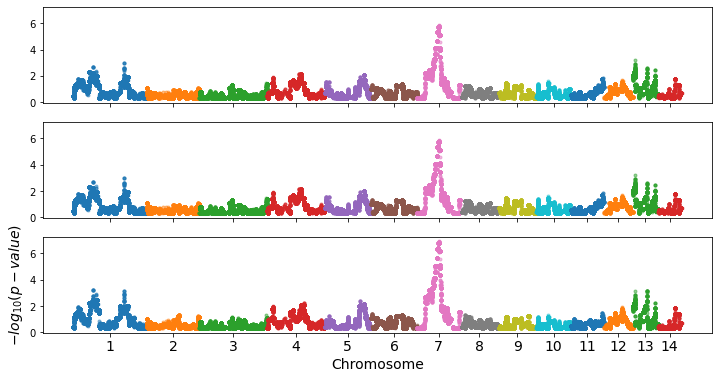

In [31]:
fig,ax = plt.subplots(3,1,figsize=(12,6),sharex=True,sharey=True)
for i,j in chrommap.iterrows():
    
    temp = qtldf[(qtldf.Chrom == j.Chrom)]
    
    plt.sca(ax[0])
    plt.plot( temp.Pos.values+j.Cumlen, 
             temp.Old.values,'.',alpha=0.5);
    
    plt.sca(ax[1])
    plt.plot( temp.Pos.values+j.Cumlen, 
             temp.Old_test.values,'.',alpha=0.5);
    
    plt.sca(ax[2])
    plt.plot( temp.Pos.values+j.Cumlen, 
             temp.New_old_test.values,'.',alpha=0.5);

plt.xticks(chrommap.Midpts.values, np.arange(1,15),fontsize=14)
plt.ylabel("$-log_{10}(p-value)$",fontsize=14);
plt.xlabel('Chromosome',fontsize=14);

In [32]:
qtlix = qtldf['New_old_test'].idxmax()
halos_newold_mean['QTL'] = gv.loc[qtlix,halos_newold_mean.index].apply(float)
halos_newold_mean.head()

,Stack,Passage,Halo,QTL
Sample,,,,
SS-A837,1.5,10.5,14.699971,1.0
SS-B307,3.0,10.0,30.490262,0.0
SS-B310,5.0,10.0,11.341913,1.0
SS-B311,4.0,10.0,6.670954,1.0
SS-B312,5.0,10.0,22.619310,0.0


In [33]:
import statsmodels.formula.api as smf
from matplotlib import rc
xl280alpha_label = 'XL280'+r'$\alpha$'
xl280a_label = 'XL280' +r'$\bf{a}$'
_431_label = '431'+r'$\mathrm{\alpha}$'

myylabel = 'Amoeba clearance area (cm$^2$)\n$\longleftarrow$resistant - sensitive$\longrightarrow$'
parentals = ['SS-A837','XL280a']#,'XL280alpha']
parental_labels = [_431_label,xl280a_label]#,xl280alpha_label]



res = smf.ols('Halo~QTL',data=halos_newold_mean).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Halo   R-squared:                       0.256
Model:                            OLS   Adj. R-squared:                  0.248
Method:                 Least Squares   F-statistic:                     32.68
Date:                Tue, 26 Jan 2021   Prob (F-statistic):           1.25e-07
Time:                        12:36:34   Log-Likelihood:                -370.11
No. Observations:                  97   AIC:                             744.2
Df Residuals:                      95   BIC:                             749.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     24.0651      1.511     15.931      0.000      21.066      27.064
QTL          -12.9699      2.269     -5.717      0.000     -17.474      -8.466
==============================================================================
Omnibus:                       13.012   Durbin-Watson:                   1.757
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               13.941
Skew:                           0.822   Prob(JB):                     0.000939
Kurtosis:                       3.864   Cond. No.                         2.51
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

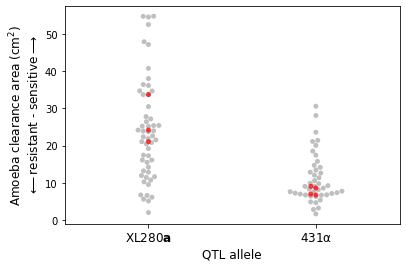

In [34]:
sns.swarmplot(x='QTL',y='Halo',data=halos_newold_mean,
             color='grey',alpha=0.5);
sns.swarmplot(x='QTL',y='Halo',
              data=halos_newold_mean.loc[strains_added,:],
             color='r',alpha=0.75);
plt.ylabel(myylabel,fontsize=12)
plt.xticks([0,1],parental_labels[::-1],fontsize=12);
plt.xlabel('QTL allele',fontsize=12);

In [35]:
halos_newold_mean.head()

,Stack,Passage,Halo,QTL
Sample,,,,
SS-A837,1.5,10.5,14.699971,1.0
SS-B307,3.0,10.0,30.490262,0.0
SS-B310,5.0,10.0,11.341913,1.0
SS-B311,4.0,10.0,6.670954,1.0
SS-B312,5.0,10.0,22.619310,0.0


In [36]:
data = new[(new.Sample.isin(gv.columns))].copy()
data.drop(['Strain','Mean','Min','Max','Area_in2','Area'],
          inplace=True,axis=1)
data.drop(waitix,axis=0,inplace=True)
data.head()

,Day,Replicate,Stack,plate,passage,issues,Area_cm2,Sample
261,1,2,2,2_2-1_2_firsthalf,4,NaN,1.445158,SS-A837
322,12,2,2,2_2-1_2_firsthalf,4,NaN,18.716092,SS-A837
421,1,2,5,2_2-1_2_secondhalf,5,NaN,1.567739,SS-A837
483,12,2,5,2_2-1_2_secondhalf,5,NaN,23.767694,SS-A837
652,1,3,4,2_3-1_3_firsthalf,7,NaN,1.193546,SS-A837


In [313]:
data['Halo'] = data.groupby(['Sample','Replicate','plate'])['Area_cm2'].diff()

In [314]:
data['QTL'] = gv.loc[qtlix,data.Sample].apply(float).values

In [456]:
datai = data[(data.issues.isna())].T[(data.columns!='issues')].T.dropna()
datai['Halo'] = datai['Halo'].apply(float)

datai.head()

,Day,Replicate,Stack,plate,passage,Area_cm2,Sample,Halo,QTL
322,12,2,2,2_2-1_2_firsthalf,4,18.7161,SS-A837,17.270933,1
483,12,2,5,2_2-1_2_secondhalf,5,23.7677,SS-A837,22.199956,1
707,12,3,4,2_3-1_3_firsthalf,7,15.2774,SS-A837,14.083843,1
552,12,3,1,2_3-1_3_secondhalf,9,13.1161,SS-A837,10.696753,1
195,12,1,1,p1_1,11,19.329,SS-A837,17.741900,1


In [457]:
datai['QTLl'] = data.QTL.replace(dict(zip([0,1],parental_labels[::-1])))

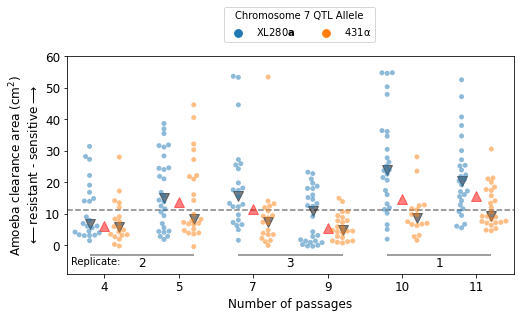

In [458]:
fig,ax = plt.subplots(1,1,figsize=(8,4))
#datai = datai[(datai.Sample.isin(common_segs))].copy()
fig.set_facecolor('w')
sns.swarmplot(x='passage',y='Halo',hue='QTLl',
              data=datai,dodge=True,alpha=0.5,
              hue_order=parental_labels[::-1])

plt.hlines(np.median(datai.Halo),-2,11,
          color='k',alpha=0.5,linestyle='--');

group_med = pd.DataFrame(datai.groupby(['passage','QTL']
                            )['Halo'].median()).reset_index()

for i in [0,1]:
    
    xgm = group_med[(group_med.QTL==i)]
    plt.plot(np.arange(0,6) - (0.2 if i == 0 else -0.2),
             xgm.Halo,'v',markersize=10,alpha=0.5,
             color='k')
    
passage_med = pd.DataFrame(datai.groupby(['passage']
                            )['Halo'].median()).reset_index()

plt.plot(passage_med.index.values,
         passage_med.Halo.values,'^',
         alpha=0.5,color='r',markersize=10)
#group_med = pd.DataFrame(datai.groupby(['passage','QTL'])['Halo'].mean()).reset_index()

#for i in [0,1]:
    
#    xgm = group_med[(group_med.QTL==i)]
#    
#    plt.plot(np.arange(0,6) - (0.2 if i == 0 else -0.2),
#             xgm.Halo,'v',markersize=10,alpha=0.5,
#             color='k')
plt.legend(bbox_to_anchor=(0.7,1.25),ncol=2,
           title='Chromosome 7 QTL Allele')

yl = 0.7
c = 0
for i in np.arange(0,6,0.5)[1::4]:
    
    plt.hlines(-3,-yl+i,yl+i,'k',alpha=0.5) 
    plt.text(i,-3.5,s=[2,3,1][c],
             va='top',ha='center',fontsize=12)
    
    c = c + 1
plt.text(-0.45,-3.5,'Replicate:',fontsize=10,va='top')
plt.ylim(-9,60);
plt.yticks(fontsize=12)
plt.ylabel(myylabel,fontsize=12)
plt.xticks(fontsize=12)
plt.xlabel('Number of passages',fontsize=12);
plt.savefig('../../FIGURES/Passage_and_QTL_effect_XL280x431.png',
           dpi=200,bbox_inches='tight');

In [493]:
res = smf.ols('Halo~passage',data=datai).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Halo   R-squared:                       0.123
Model:                            OLS   Adj. R-squared:                  0.107
Method:                 Least Squares   F-statistic:                     7.611
Date:                Tue, 26 Jan 2021   Prob (F-statistic):           1.04e-06
Time:                        15:11:55   Log-Likelihood:                -1071.2
No. Observations:                 278   AIC:                             2154.
Df Residuals:                     272   BIC:                             2176.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         9.6101      1.780      5.400      0.000       6.106      13.114
passage[T.5]      6.7476      2.403      2.808      0.005       2.016      11.479
passage[T.7]      5.1035      2.517      2.028      0.044       0.148      10.059
passage[T.9]     -1.6787      2.425     -0.692      0.489      -6.454       3.096
passage[T.10]    10.5812      2.517      4.204      0.000       5.626      15.536
passage[T.11]     7.7026      2.393      3.219      0.001       2.992      12.414
==============================================================================
Omnibus:                       57.859   Durbin-Watson:                   1.705
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               91.834
Skew:                           1.210   Prob(JB):                     1.14e-20
Kurtosis:                       4.438   Cond. No.                         7.17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [494]:
datai['Corhalo'] = res.resid

<AxesSubplot:xlabel='passage', ylabel='Corhalo'>

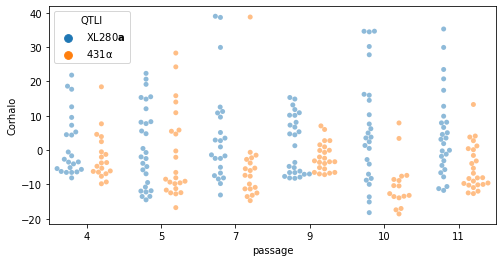

In [495]:
fig,ax = plt.subplots(1,1,figsize=(8,4))
fig.set_facecolor('w')
sns.swarmplot(x='passage',y='Corhalo',hue='QTLl',
              data=datai,dodge=True,alpha=0.5,
              hue_order=parental_labels[::-1])

In [505]:
data12s = datai.groupby(['Sample','Replicate']).mean()
data12s.reset_index(inplace=True)

In [506]:
data12s

,Sample,Replicate,Halo,Corhalo
0,SS-A837,1,14.699971,-4.052080
1,SS-A837,2,19.735444,6.751527
2,SS-A837,3,12.390298,1.067784
3,SS-B307,1,30.490262,10.298904
4,SS-B307,2,12.509652,-3.848063
...,...,...,...,...
266,XL280a,1,25.387046,6.634995
267,XL280a,2,3.399993,-6.210126
268,XL280a,3,-0.180645,-8.112031
269,XL280alpha,1,21.541892,1.350535


In [507]:
## Cunduct QTL mapping on each replicate
pval_cols = []
pheno = 'Corhalo'
for r in reps:
    ## Gather replicate and set index
    rep = data12s[(data12s.Replicate==r)].copy()
    rep.index = rep.Sample
    #rep = rep.loc[common_segs]
    ## Gather unique loci and check work
    loci = gv[rep.index].drop_duplicates()
    #assert loci.shape[1] == len(np.unique(rep.index))
    
    ## QTL map, set name of column and append
    newcol = 'Pval%s'%r
    loci[newcol] = loci.apply(allelic_manu,
                            args=[rep[pheno].values],axis=1)
    
    #loci[newcol] = loci.apply(crypto_kruskal,
    #                        args=[rep[pheno].values],axis=1)
    
    #loci[newcol] = loci.apply(allelic_ANOVA,
    #                        args=[rep[pheno].values],axis=1)
    
    
    ## Append list of QTL columns and merge to genotype ata
    pval_cols.append(newcol)
    qtldf[newcol] = gv.merge(loci)[newcol]

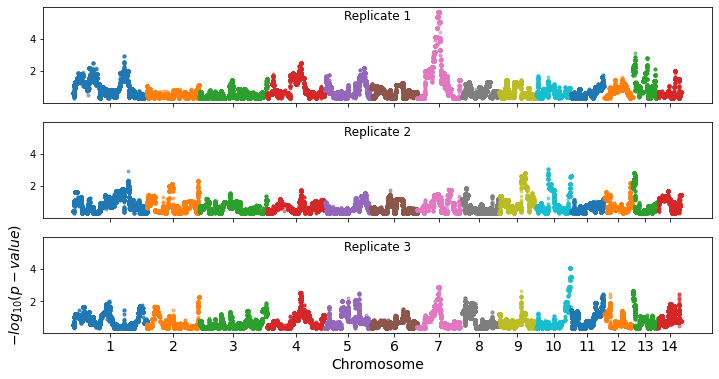

In [508]:
## QTL plots per replicate
fig,ax = plt.subplots(3,1,figsize=(12,6),sharex=True,sharey=True)
fig.set_facecolor('w')
for ri,p in enumerate(pval_cols):
    plt.sca(ax[ri])
    
    plt.title('Replicate %s'%str(ri+1),fontsize=12,y=0.8)

    for i,j in chrommap.iterrows():
    
        temp = qtldf[(qtldf.Chrom == j.Chrom)]
    
      
        plt.plot(temp.Pos.values+j.Cumlen, 
                 temp[p].values,'.',alpha=0.5);

plt.xticks(chrommap.Midpts.values, np.arange(1,15),fontsize=14)
plt.ylabel("$-log_{10}(p-value)$",fontsize=14);
plt.xlabel('Chromosome',fontsize=14)
plt.savefig('../../FIGURES/XL280x431_amoeba_assay_QTL_by_replicate.png',
           dpi=200,bbox_inches='tight')


<AxesSubplot:>

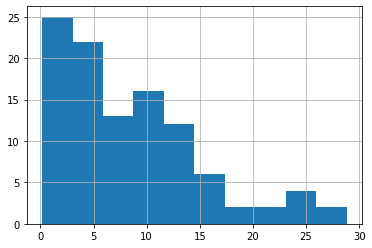

In [510]:
data12s.groupby('Sample').std().Halo.hist()

In [478]:
dg = [sg for i,sg in 
      datai.groupby(['Sample','Replicate','plate']) ]

In [479]:
ratios = []
rix = []

for d in dg:
    r = d['Area_cm2'].max()/d['Area_cm2'].min()
    
    ratios.append(r)
    rix.append(d.index.max())
    
ratiodf = pd.Series(ratios,index=rix)

In [480]:
colors= ['r','b','k']

In [492]:
datai.groupby('Replicate').count()

,Day,Stack,plate,passage,Area_cm2,Sample,Halo,QTL,QTLl,Corhalo
Replicate,,,,,,,,,,
1,94,94,94,94,94,94,94,94,94,94
2,93,93,93,93,93,93,93,93,93,93
3,91,91,91,91,91,91,91,91,91,91


In [481]:
k.Replicate

533    3
589    3
Name: Replicate, dtype: int64

In [484]:
assert data12[(data12.Day==1)].shape[0] == 0

In [485]:
data12[['Replicate','plate']].drop_duplicates()

,Replicate,plate
322,2,2_2-1_2_firsthalf
483,2,2_2-1_2_secondhalf
707,3,2_3-1_3_firsthalf
552,3,2_3-1_3_secondhalf
195,1,p1_1
142,1,p2_1


In [486]:
data12[(data12.Sample=='SS-B307')]

,Day,Replicate,Stack,plate,passage,Area_cm2,Sample,Halo,QTL,Ratio
473,12,2,4,2_2-1_2_secondhalf,5,16.993514,SS-B307,12.509652,0.0,1.0
557,12,3,1,2_3-1_3_secondhalf,9,20.070928,SS-B307,18.096738,0.0,1.0
154,12,1,3,p2_1,10,34.612834,SS-B307,30.490262,0.0,1.0


In [489]:
data12

,Day,Replicate,Stack,plate,passage,Area_cm2,Sample,Halo,QTL,Ratio
322,12,2,2,2_2-1_2_firsthalf,4,18.716092,SS-A837,17.270933,1.0,1.0
483,12,2,5,2_2-1_2_secondhalf,5,23.767694,SS-A837,22.199956,1.0,1.0
707,12,3,4,2_3-1_3_firsthalf,7,15.277389,SS-A837,14.083843,1.0,1.0
552,12,3,1,2_3-1_3_secondhalf,9,13.116103,SS-A837,10.696753,1.0,1.0
195,12,1,1,p1_1,11,19.328994,SS-A837,17.741900,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...
598,12,3,5,2_3-1_3_secondhalf,9,0.174193,XL280a,-0.180645,0.0,1.0
194,12,1,1,p1_1,11,31.025744,XL280a,30.077359,0.0,1.0
164,12,1,4,p2_1,10,21.696731,XL280a,20.696733,0.0,1.0
472,12,2,4,2_2-1_2_secondhalf,5,3.825799,XL280alpha,2.858059,0.0,1.0


In [140]:
data12s = data12.groupby(['Sample','Replicate']
                        ).mean().reset_index().copy()

In [141]:
halos_newold_mean.loc[parentals]

,Stack,Passage,Halo,QTL
Sample,,,,
SS-A837,1.5,10.5,14.699971,1.0
XL280a,2.5,10.5,25.387046,0.0


In [142]:
data12s[(data12s.Sample.isin(parentals)) & (data12s.Replicate==1)]

,Sample,Replicate,Day,Stack,passage,Area_cm2,Halo,Ratio
0,SS-A837,1,12.0,1.5,10.5,16.229000,14.699971,10.55215
266,XL280a,1,12.0,2.5,10.5,26.361238,25.387046,27.20553


In [143]:
reps = data12s.Replicate.unique()
reps

array([1, 2, 3])

In [144]:
ranks = pd.concat([np.argsort(data12s[
    (data12s.Replicate==r)].Halo) 
                   for r in reps])
data12s['Repranks'] = ranks

In [154]:
segsxrep = [ set(d.Sample.unique()) 
            for i, d in data12s.groupby(['Replicate'])]

In [165]:
common_segs = set.intersection(segsxrep[0],segsxrep[1],segsxrep[2])

In [167]:
len(common_segs)

63

In [ ]:
data12s

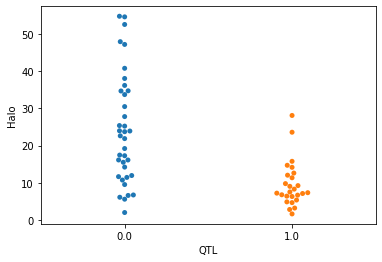

In [170]:
sns.swarmplot(x='QTL',y='Halo',
              data=halos_newold_mean.loc[common_segs,:]);

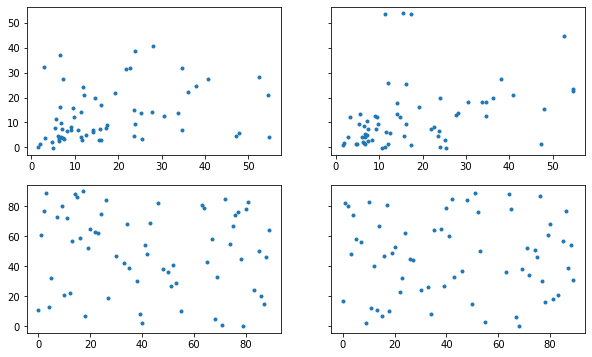

In [176]:
data12s.sort_values(['Sample','Replicate'],inplace=True)

fig, ax = plt.subplots(2,2,figsize=(10,6),
                       sharey='row',sharex='row')

x = data12s[(data12s.Replicate==1)].copy()
x.index = x.Sample
x.drop(['Sample'],axis=1,inplace=True)

for r in reps[1:]:
    plt.sca(ax[0,int(r-2)])
        
    y = data12s[(data12s.Replicate==r)].copy()
    y.index = y.Sample
    y.drop(['Sample'],axis=1,inplace=True)
    
    plt.plot(x.loc[common_segs,'Halo'].values, 
             y.loc[common_segs,'Halo'].values,'.')
    
    plt.sca(ax[1,int(r-2)])
    plt.plot(x.loc[common_segs,'Repranks'].values, 
             y.loc[common_segs,'Repranks'].values,'.')

In [198]:
data12s.groupby('Sample')

array([3, 2])

In [204]:
data12s['Passage'] = np.round(data12s.passage)

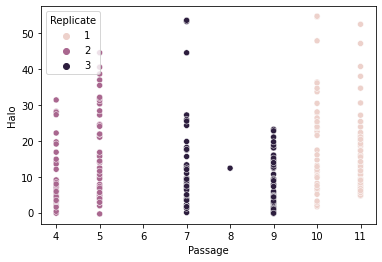

In [230]:
sns.scatterplot(x='Passage',y='Halo',
                data=data12s,hue='Replicate');

In [213]:
data12sq = data12s.merge(halos_newold_mean.reset_index()[['Sample','QTL']])

In [215]:
data12sq.head()

,Sample,Replicate,Day,Stack,passage,Area_cm2,Halo,Ratio,Repranks,Passage,QTL
0,SS-A837,1,12.0,1.5,10.5,16.229000,14.699971,10.552150,33,10.0,1.0
1,SS-A837,2,12.0,3.5,4.5,21.241893,19.735444,14.055693,42,4.0,1.0
2,SS-A837,3,12.0,2.5,8.0,14.196746,12.390298,9.110667,26,8.0,1.0
3,SS-B307,1,12.0,3.0,10.0,34.612834,30.490262,8.395931,51,10.0,0.0
4,SS-B307,2,12.0,4.0,5.0,16.993514,12.509652,3.789928,27,5.0,0.0


In [441]:
## Cunduct QTL mapping on each replicate
pval_cols = []
pheno = 'Halo'
for r in reps:
    ## Gather replicate and set index
    rep = data12s[(data12s.Replicate==r)].copy()
    rep.index = rep.Sample
    #rep = rep.loc[common_segs]
    ## Gather unique loci and check work
    loci = gv[rep.index].drop_duplicates()
    #assert loci.shape[1] == len(np.unique(rep.index))
    
    ## QTL map, set name of column and append
    newcol = 'Pval%s'%r
    loci[newcol] = loci.apply(allelic_manu,
                            args=[rep[pheno].values],axis=1)
    
    #loci[newcol] = loci.apply(crypto_kruskal,
    #                        args=[rep[pheno].values],axis=1)
    
    #loci[newcol] = loci.apply(allelic_ANOVA,
    #                        args=[rep[pheno].values],axis=1)
    
    
    ## Append list of QTL columns and merge to genotype ata
    pval_cols.append(newcol)
    qtldf[newcol] = gv.merge(loci)[newcol]

In [443]:
pval_cols

['Pval1', 'Pval2', 'Pval3']

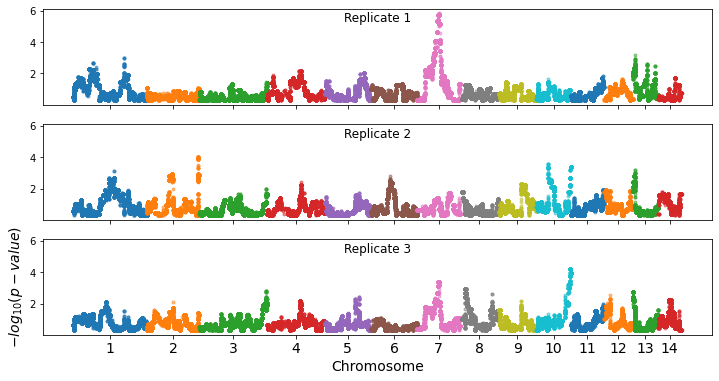

In [447]:
## QTL plots per replicate
fig,ax = plt.subplots(3,1,figsize=(12,6),sharex=True,sharey=True)
fig.set_facecolor('w')
for ri,p in enumerate(pval_cols):
    plt.sca(ax[ri])
    
    plt.title('Replicate %s'%str(ri+1),fontsize=12,y=0.8)

    for i,j in chrommap.iterrows():
    
        temp = qtldf[(qtldf.Chrom == j.Chrom)]
    
      
        plt.plot(temp.Pos.values+j.Cumlen, 
                 temp[p].values,'.',alpha=0.5);

plt.xticks(chrommap.Midpts.values, np.arange(1,15),fontsize=14)
plt.ylabel("$-log_{10}(p-value)$",fontsize=14);
plt.xlabel('Chromosome',fontsize=14)
plt.savefig('../../FIGURES/XL280x431_amoeba_assay_QTL_by_replicate.png',
           dpi=200,bbox_inches='tight')
